<a href="https://colab.research.google.com/github/ahforoughi/driver-scoring-fuzzy-logic/blob/main/driver_point_fuzzy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install -U scikit-fuzzy

     |████████████████████████████████| 1.0MB 4.0MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp37-none-any.whl size=894088 sha256=a6613954e55e1456cba27f107d59faac8076b7ac1fdec6f8c862baf74450a992
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


In [3]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

In [4]:
# Generate universe variables
#   * Quality and behavior on subjective ranges [0, 5]
#   * score has a range of [0, 10] in units of percentage points
x_quality = np.arange(0, 6, 1)
x_behavior = np.arange(0, 6, 1)
x_score  = np.arange(0, 11, 1)

In [5]:
# Generate fuzzy membership functions
quality_low = fuzz.trimf(x_quality, [0, 0, 2])
quality_mid = fuzz.trimf(x_quality, [0, 2, 5])
quality_high = fuzz.trimf(x_quality, [2, 5, 5])
behavior_low = fuzz.trimf(x_behavior, [0, 0, 2])
behavior_mid = fuzz.trimf(x_behavior, [0, 2, 5])
behavior_high = fuzz.trimf(x_behavior, [2, 5, 5])
score_low = fuzz.trimf(x_score, [0, 0, 5])
score_mid = fuzz.trimf(x_score, [0, 5, 10])
score_high = fuzz.trimf(x_score, [5, 10, 10])


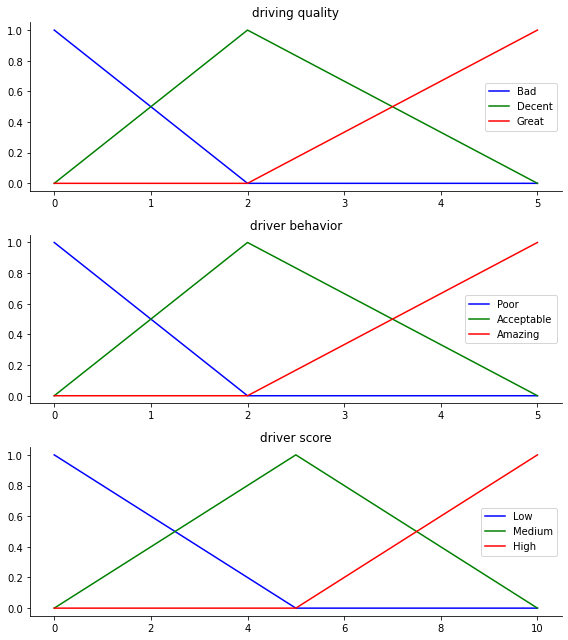

In [6]:
# Visualize these universes and membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

ax0.plot(x_quality, quality_low, 'b', linewidth=1.5, label='Bad')
ax0.plot(x_quality, quality_mid, 'g', linewidth=1.5, label='Decent')
ax0.plot(x_quality, quality_high, 'r', linewidth=1.5, label='Great')
ax0.set_title('driving quality')
ax0.legend()

ax1.plot(x_behavior, behavior_low, 'b', linewidth=1.5, label='Poor')
ax1.plot(x_behavior, behavior_mid, 'g', linewidth=1.5, label='Acceptable')
ax1.plot(x_behavior, behavior_high, 'r', linewidth=1.5, label='Amazing')
ax1.set_title('driver behavior')
ax1.legend()

ax2.plot(x_score, score_low, 'b', linewidth=1.5, label='Low')
ax2.plot(x_score, score_mid, 'g', linewidth=1.5, label='Medium')
ax2.plot(x_score, score_high, 'r', linewidth=1.5, label='High')
ax2.set_title('driver score')
ax2.legend()

# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

In [14]:
# We need the activation of our fuzzy membership functions at these values.
# The exact values 6.5 and 9.8 do not exist on our universes...
# This is what fuzz.interp_membership exists for!
quality_level_low = fuzz.interp_membership(x_quality, quality_low, 3.5)
quality_level_mid = fuzz.interp_membership(x_quality, quality_mid, 3.5)
quality_level_high = fuzz.interp_membership(x_quality, quality_high, 3.5)

behavior_level_low = fuzz.interp_membership(x_behavior, behavior_low, 4.8)
behavior_level_mid = fuzz.interp_membership(x_behavior, behavior_mid, 4.8)
behavior_level_high = fuzz.interp_membership(x_behavior, behavior_high, 4.8)


In [11]:
# Now we take our rules and apply them. Rule 1 concerns bad behavior OR driving quality.
# The OR operator means we take the maximum of these two.
active_rule1 = np.fmax(quality_level_low, behavior_level_low)

In [19]:
# Now we apply this by clipping the top off the corresponding output
# membership function with `np.fmin`
score_activation_low = np.fmin(active_rule1, score_low)  # removed entirely to 0

In [20]:
# For rule 2 we connect acceptable behavior to medium score
score_activation_mid = np.fmin(behavior_level_mid, score_mid)

In [25]:
# For rule 3 we connect high behavior OR high driving quality with high score
active_rule3 = np.fmax(quality_level_high, behavior_level_high)
score_activation_high = np.fmin(active_rule3, score_high)
score0 = np.zeros_like(x_score)

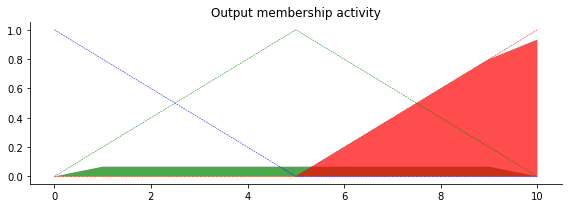

In [30]:
# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.fill_between(x_score, score0, score_activation_low, facecolor='b', alpha=0.7)
ax0.plot(x_score, score_low, 'b', linewidth=0.5, linestyle='--', )
ax0.fill_between(x_score, score0, score_activation_mid, facecolor='g', alpha=0.7)
ax0.plot(x_score, score_mid, 'g', linewidth=0.5, linestyle='--')
ax0.fill_between(x_score, score0, score_activation_high, facecolor='r', alpha=0.7)
ax0.plot(x_score, score_high, 'r', linewidth=0.5, linestyle='--')
ax0.set_title('Output membership activity')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

In [31]:
# Aggregate all three output membership functions together
aggregated = np.fmax(score_activation_low,
                     np.fmax(score_activation_mid, score_activation_high))


In [32]:
# Calculate defuzzified result
score = fuzz.defuzz(x_score, aggregated, 'centroid')
score_activation = fuzz.interp_membership(x_score, aggregated, score)  # for plot


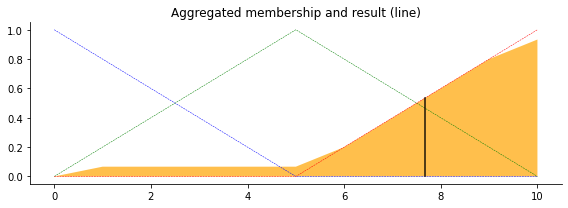

In [34]:
# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.plot(x_score, score_low, 'b', linewidth=0.5, linestyle='--', )
ax0.plot(x_score, score_mid, 'g', linewidth=0.5, linestyle='--')
ax0.plot(x_score, score_high, 'r', linewidth=0.5, linestyle='--')
ax0.fill_between(x_score, score0, aggregated, facecolor='Orange', alpha=0.7)
ax0.plot([score, score], [0, score_activation], 'k', linewidth=1.5, alpha=0.9)
ax0.set_title('Aggregated membership and result (line)')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()